#  제조 공정간 불량 예측



## pulp-and-paper mill 공정
* 비즈니스 상황
    * 한 롤로 종이를 말다가 찢어지는 사고가 하루에 한번 이상 발생
    * 이때마다 공정 중단 및 수율 저하 등, 평균적으로 100백만원의 손실
    * 이를 사전에 감지하는 것은 굉장히 어려운 일입니다. 이런 사고를 5%만 감소시키더라도 회사 입장에서는 상당한 비용 절감 효과가 예상됩니다.

* Data
    * 행
        * 주어진 데이터에는 15일 동안 수집된 약 18,000개의 행의 시계열 데이터
        * 데이터는 2분 간격으로 측정.
    * 열 
        * y : normal – 0, abnormal - 1 (124건, 약 0.6%)
            * y 의 abnormal 데이터는 장애 발생 2~4분 전으로 시점에 대한 조정(shift)이 된(전처리 된) 데이터 입니다.
        * x1 - x61: 원자재, 부자재 및 공정 센서 값들로 구성됨.

* 장애 예방 조치
    * 장애가 예상된다면, 속도를 줄여 장애를 예방할 수 있습니다.
    * 단, 속도를 줄이면 생산성이 저하되므로, 1회당 평균 3만원의 손실이 발생됩니다.


![](https://keralakaumudi.com/web-news/en/2020/04/NMAN0141956/image/paper-mill.1.582102.jpg)

## 0.환경준비

### 1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.backend import clear_session

### 2) 데이터셋 불러오기

In [2]:
# 공정 데이터 불러오기
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/processminer2.csv"
data = pd.read_csv(path)
data.head()

,y,time,x1,x2,x3,x4,x5,x6,x7,x8,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
0,0.0,5/1/99 0:00,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076
1,0.0,5/1/99 0:02,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083
2,0.0,5/1/99 0:04,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090
3,0.0,5/1/99 0:06,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097
4,0.0,5/1/99 0:08,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105


### 3) 필요 함수들 생성

### 0.2 필요 함수들 생성

#### ① reconstruction error plot

* input과 output의 차이(mse)를 계산하고
* 시각화 합니다.



In [3]:
def recon_err_plot(x, x_pred, y, threshold=0):
    # treshold : 우리가 지정해줘야 함.(어떻게?)
    
    mse = np.mean(np.power(x - x_pred, 2), axis=1)
    error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y})
    error_df = error_df.reset_index()

    groups = error_df.groupby('True_class')
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Abnormal" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show()

    return error_df

#### ② precision, recall, f1 curve

> * sklearn에서는 precision, recall curve만 제공됩니다. 
* 그래서, f1 curve도 추가해서 구하고, plot을 그립니다.



In [4]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def prec_rec_f1_curve(y, score, pos = 1) :
    precision, recall, thresholds  = precision_recall_curve(y, score, pos_label=1)
    f1 = 2 / (1/precision + 1/recall)

    plt.plot(thresholds, np.delete(precision, -1), label = 'precision')
    plt.plot(thresholds, np.delete(recall, -1), label = 'recall')
    plt.plot(thresholds, np.delete(f1, -1), label = 'f1')
    plt.xlabel('thresholds')
    plt.legend()
    plt.grid()
    plt.show()

    return precision, recall, f1, thresholds

#### ③ threshold로 잘랐을 때, 분류 평가 함수


In [5]:
from sklearn.metrics import confusion_matrix, classification_report

def classification_report2(y, pred, thresholds):
    pred_temp = np.where(pred > thresholds , 1, 0)

    print('< confusion matrix >\n')
    print(confusion_matrix(y, pred_temp))
    print('\n' + '='*60 + '\n')

    print('< classification_report >\n')
    print(classification_report(y, pred_temp))

## 1.데이터 탐색

In [6]:
target = 'y'

* Target 변수의 class 비율을 확인해 봅시다.

In [7]:
print(data[target].value_counts())
print(data[target].value_counts() / data.shape[0])


0.0    18150
1.0      124
Name: y, dtype: int64
0.0    0.993214
1.0    0.006786
Name: y, dtype: float64


## 2.데이터 준비

### 2.2 추가변수

In [8]:
for v in data.columns[2:] :
    var = v + '_diff'
    data[var] = data[v] - data[v].shift()

data.dropna(axis = 0, inplace = True)

### 2.1 x, y로 분할하기

* 불필요한 변수 제거

In [9]:
data.drop('time', axis = 1, inplace = True)

In [10]:
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### 2.3 데이터 분할
* data ==> train : val = 7 : 3
* stratify=y : y의 class 비율을 유지하면서 분할하기

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .3, random_state=2022, stratify=y)

In [12]:
y_train.value_counts()/len(y_train)

0.0    0.993198
1.0    0.006802
Name: y, dtype: float64

In [13]:
y_val.value_counts()/len(y_val)

0.0    0.993251
1.0    0.006749
Name: y, dtype: float64

In [14]:
y_val.value_counts()

0.0    5445
1.0      37
Name: y, dtype: int64

### 2.4 스케일링

In [15]:
scaler = MinMaxScaler()

x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

### 2.5 학습용 데이터 만들기
Normal 데이터만 사용합니다.

In [16]:
x_train0 = x_train_s[y_train == 0]

In [17]:
x_train0.shape

(12704, 118)

## 3.모델링 : One Class SVM


In [18]:
from sklearn.svm import OneClassSVM

### 3.1 기본 모델링

* default로 모델을 생성하고
* 예측하고
* 평가합니다.

In [26]:
model = OneClassSVM()
model.fit(x_train0)
y_pred = model.predict(x_val_s)

In [27]:
y_pred

array([ 1, -1,  1, ..., -1,  1, -1], dtype=int64)

In [28]:
y_pred = np.where(y_pred==1,0,1)

In [29]:
print(f1_score(y_val, y_pred))

0.014684287812041117


### 3.2 nu 값 최적화

* nu 값을 조정하며 튜닝을 합시다.
* for loop를 이용해야 합니다.

* nu 값을 0.001 ~ 1사이에서 조금씩 조정하며 20개 값으로 실험해 봅시다.

In [30]:
nu_num = np.linspace(0.001, 1, 20)
f1 = []

for nu in nu_num :
    model = OneClassSVM(nu = nu)
    model.fit(x_train0)
    y_pred = model.predict(x_val_s)
    y_pred = np.where(y_pred == 1,0,1)
    f1.append(f1_score(y_val, y_pred))

* f1 값이 최대화 될 때의 nu 값을 뽑아 봅시다.

In [41]:
nu_max = nu_num[np.argmax(f1)]
nu_max, max(f1)

(0.05357894736842105, 0.026402640264026403)

* 이제 차트를 그려서 추세를 분석해 봅시다.

nu : 0.05357894736842105, f1_max : 0.026402640264026403


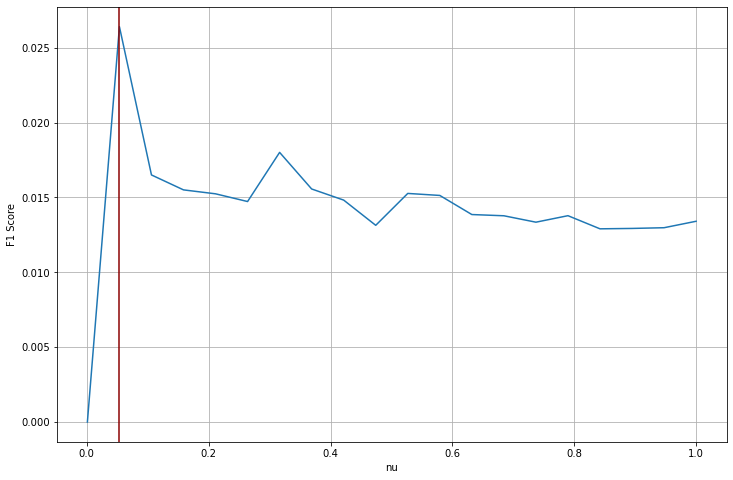

In [42]:
print( f'nu : {nu_max}, f1_max : {max(f1)}')

plt.figure(figsize=(12, 8))
plt.plot(nu_num, f1)
plt.axvline(nu_max, color = 'darkred')
plt.ylabel('F1 Score')
plt.xlabel('nu')
plt.grid()
plt.show()

* 최적의 nu 값으로 다시 모델링 합시다.

In [46]:
model = OneClassSVM(nu = nu_max)
model.fit(x_train0)
y_pred = model.predict(x_val_s)
y_pred = np.where(y_pred == 1,0,1)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97      5445
         1.0       0.02      0.11      0.03        37

    accuracy                           0.95      5482
   macro avg       0.50      0.53      0.50      5482
weighted avg       0.99      0.95      0.97      5482

[[5183  262]
 [  33    4]]


## 4.모델링 : AE

### 4.1 모델 설계

* 간단한 hyper parameter 설정

In [50]:
epochs = 50
input_dim=x_train0.shape[1]
tf.random.set_seed(10)

In [51]:
input_dim

118

* 모델 설계

In [53]:
clear_session()

il = Input(shape = (input_dim,))

encoder = Dense(100, activation = 'relu')(il)
encoder = Dense(50, activation = 'relu')(encoder)

decoder = Dense(100, activation = 'relu')(encoder)
decoder = Dense(input_dim, activation = 'relu')(decoder)

autoencoder = Model(il, decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 118)]             0         
                                                                 
 dense (Dense)               (None, 100)               11900     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 100)               5100      
                                                                 
 dense_3 (Dense)             (None, 118)               11918     
                                                                 
Total params: 33,968
Trainable params: 33,968
Non-trainable params: 0
_________________________________________________________________


* compile + 학습
    * 학습시 x=x_train0, y=x_train0를 입력합니다. (비지도)

In [54]:
autoencoder.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

history = autoencoder.fit(x_train0, x_train0, epochs = epochs, validation_data = (x_val_s, x_val_s), verbose = 1).history

Epoch 1/50
397/397 [==============================] - 2s 3ms/step - loss: 0.1065 - accuracy: 0.0054 - val_loss: 0.0885 - val_accuracy: 0.0031
Epoch 2/50
397/397 [==============================] - 1s 2ms/step - loss: 0.0812 - accuracy: 0.0068 - val_loss: 0.0785 - val_accuracy: 0.0119
Epoch 3/50
397/397 [==============================] - 1s 2ms/step - loss: 0.0763 - accuracy: 0.0224 - val_loss: 0.0728 - val_accuracy: 0.0109
Epoch 4/50
397/397 [==============================] - 1s 2ms/step - loss: 0.0697 - accuracy: 0.0229 - val_loss: 0.0610 - val_accuracy: 0.0352
Epoch 5/50
397/397 [==============================] - 1s 2ms/step - loss: 0.0598 - accuracy: 0.0277 - val_loss: 0.0552 - val_accuracy: 0.0224
Epoch 6/50
397/397 [==============================] - 1s 2ms/step - loss: 0.0545 - accuracy: 0.0322 - val_loss: 0.0525 - val_accuracy: 0.0336
Epoch 7/50
397/397 [==============================] - 1s 2ms/step - loss: 0.0523 - accuracy: 0.0361 - val_loss: 0.0506 - val_accuracy: 0.0460
Epoch 

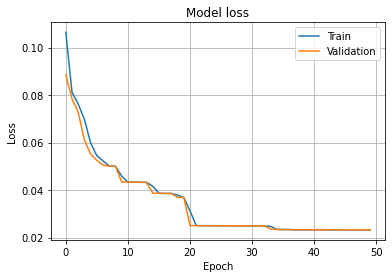

In [55]:
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

### 4.2 예측 및 Reconstruction Error 계산

* 예측

In [56]:
y_pred = autoencoder.predict(x_val_s)

* 재구성 에러 계산

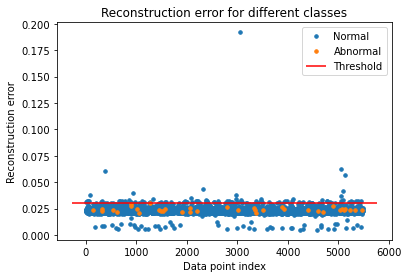

In [57]:
result = recon_err_plot(x_val_s, y_pred, y_val, 0.03)

## 5.비즈니스 관점의 모델 평가

f1 score가 아닌 비용을 모델을 평가해 봅니다.

* 비즈니스 상황
    * 한 롤로 종이를 말다가 찢어지는 사고가 하루에 한번 이상 발생
    * 이때마다 공정 중단 및 수율 저하 등, 평균적으로 100백만원의 손실
    * 이를 사전에 감지하는 것은 굉장히 어려운 일입니다. 이런 사고를 5%만 감소시키더라도 회사 입장에서는 상당한 비용 절감 효과가 예상됩니다.

* 장애 예방 조치
    * 장애가 예상된다면, 속도를 줄여 장애를 예방할 수 있습니다.
    * 단, 속도를 줄이면 생산성이 저하되므로, 1회당 평균 3만원의 손실이 발생됩니다.

* 비즈니스 기대가치 매트릭스 만들기

In [60]:
bv = np.array([[0,-3],[-100,-3]])
bv

array([[   0,   -3],
       [-100,   -3]])

* 비용계산

In [62]:
cm = np.array([[5183,262],[33,4]])

In [63]:
cm_p = cm / np.sum(cm)

In [65]:
print(np.sum(bv * cm_p))

-0.7475373951112733
